In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import scanpy as sc
import scipy as sp
import anndata as ad
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
in_dir = '../../results/08_mouse_ssc/03_annotation'
out_dir = '../../results/08_mouse_ssc/05_myeloid_subclustering'
os.makedirs(out_dir, exist_ok=True)

In [3]:
adata = sc.read_h5ad(f'{in_dir}/adata.h5ad')

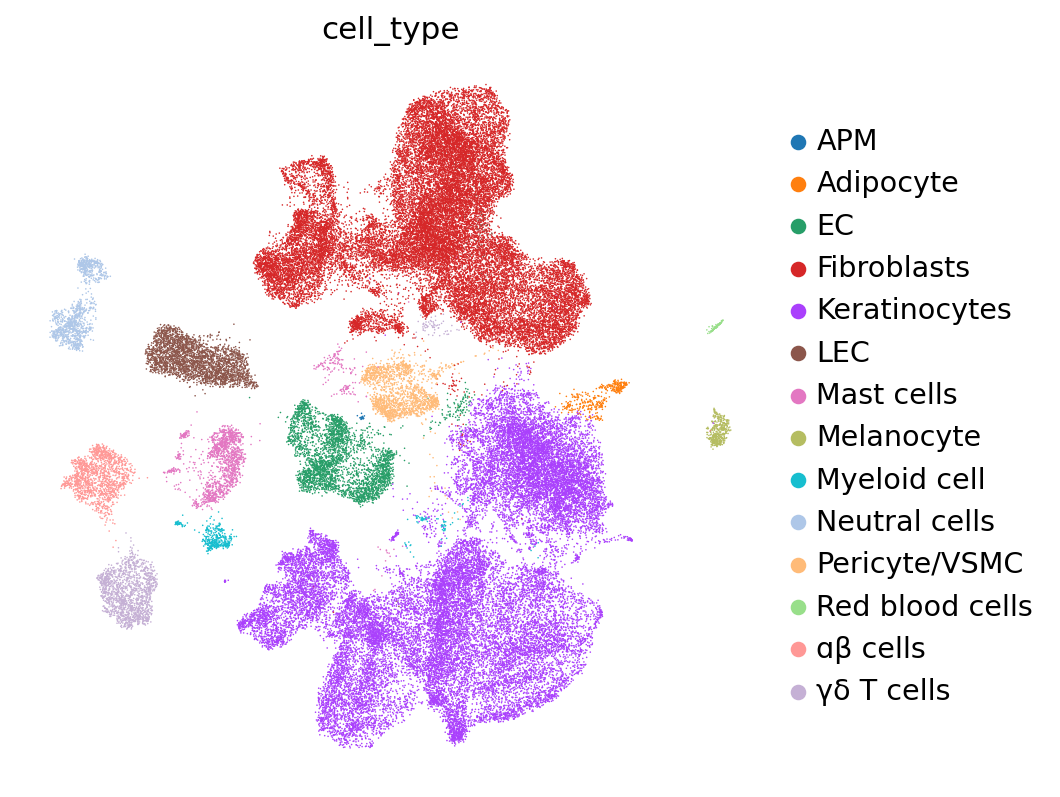

In [4]:
sc.set_figure_params(figsize=(6, 6))

sc.pl.umap(adata, color=["cell_type"], size=2, frameon=False)

In [5]:
# subset all fibroblast cells
adata = adata[adata.obs['cell_type'].isin(['Myeloid cell']), :].copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 468 × 18503
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'n_genes', 'time_point', 'leiden', 'cell_type'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'time_point_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

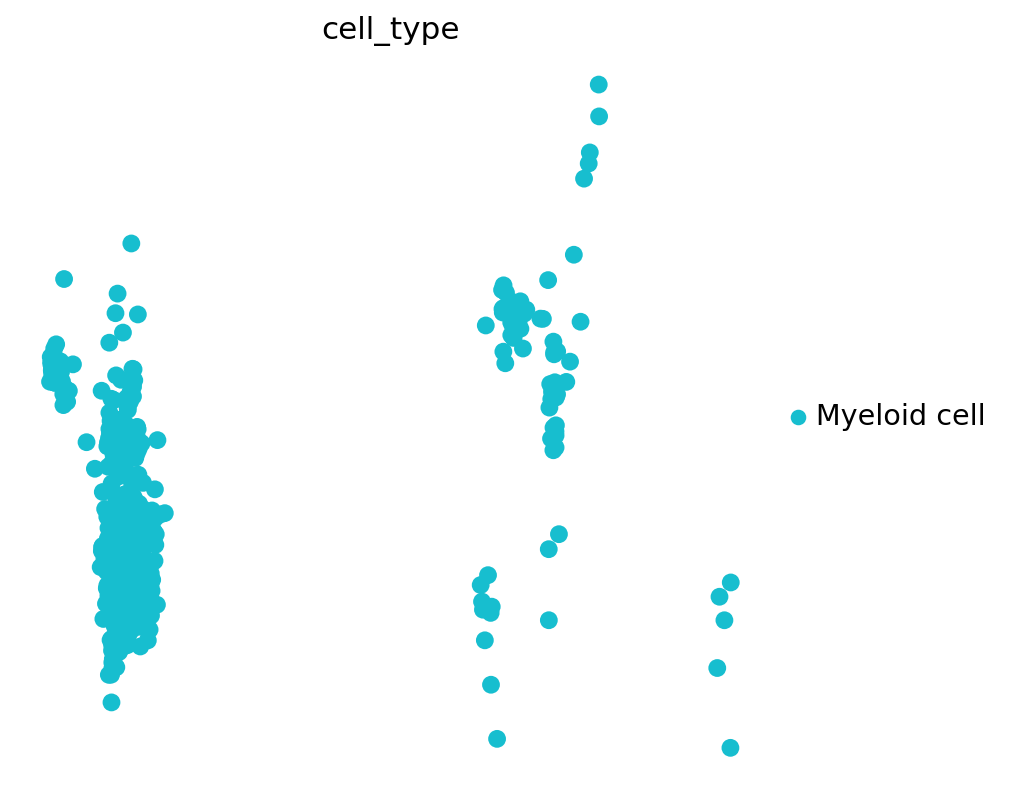

In [7]:
sc.pl.umap(adata, color=['cell_type'], frameon=False)

In [8]:
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)

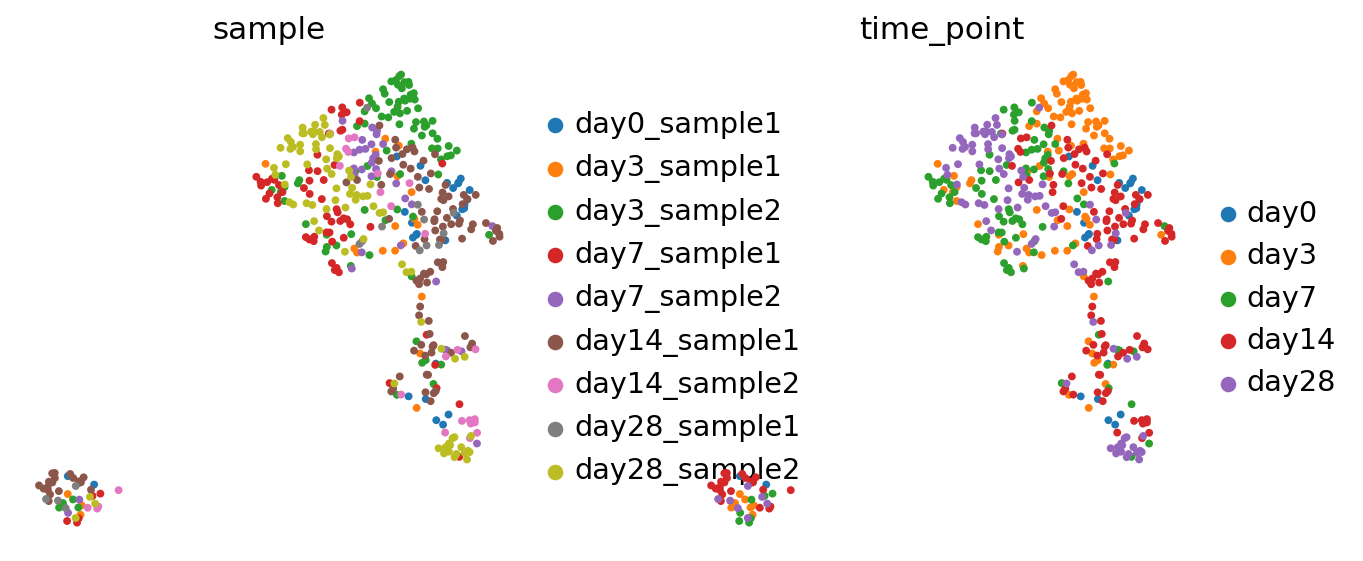

In [9]:
sc.set_figure_params(figsize=(4, 4))

sc.pl.umap(adata, color=['sample', 'time_point'], frameon=False, size=50)

In [10]:
sc.tl.leiden(adata, key_added="leiden", resolution=0.2)

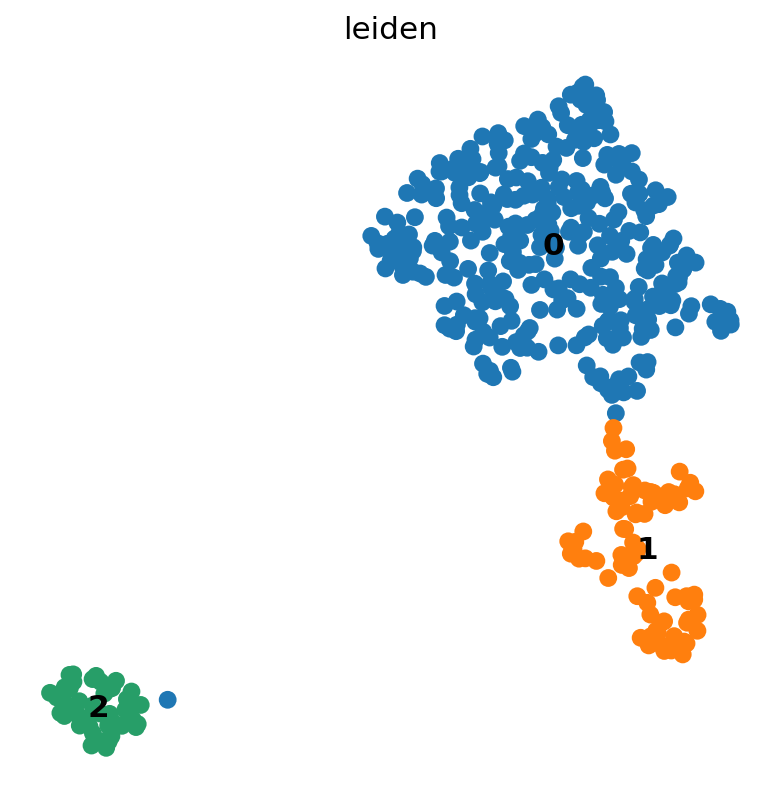

In [11]:
sc.set_figure_params(figsize=(6, 6))

sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc='on data')

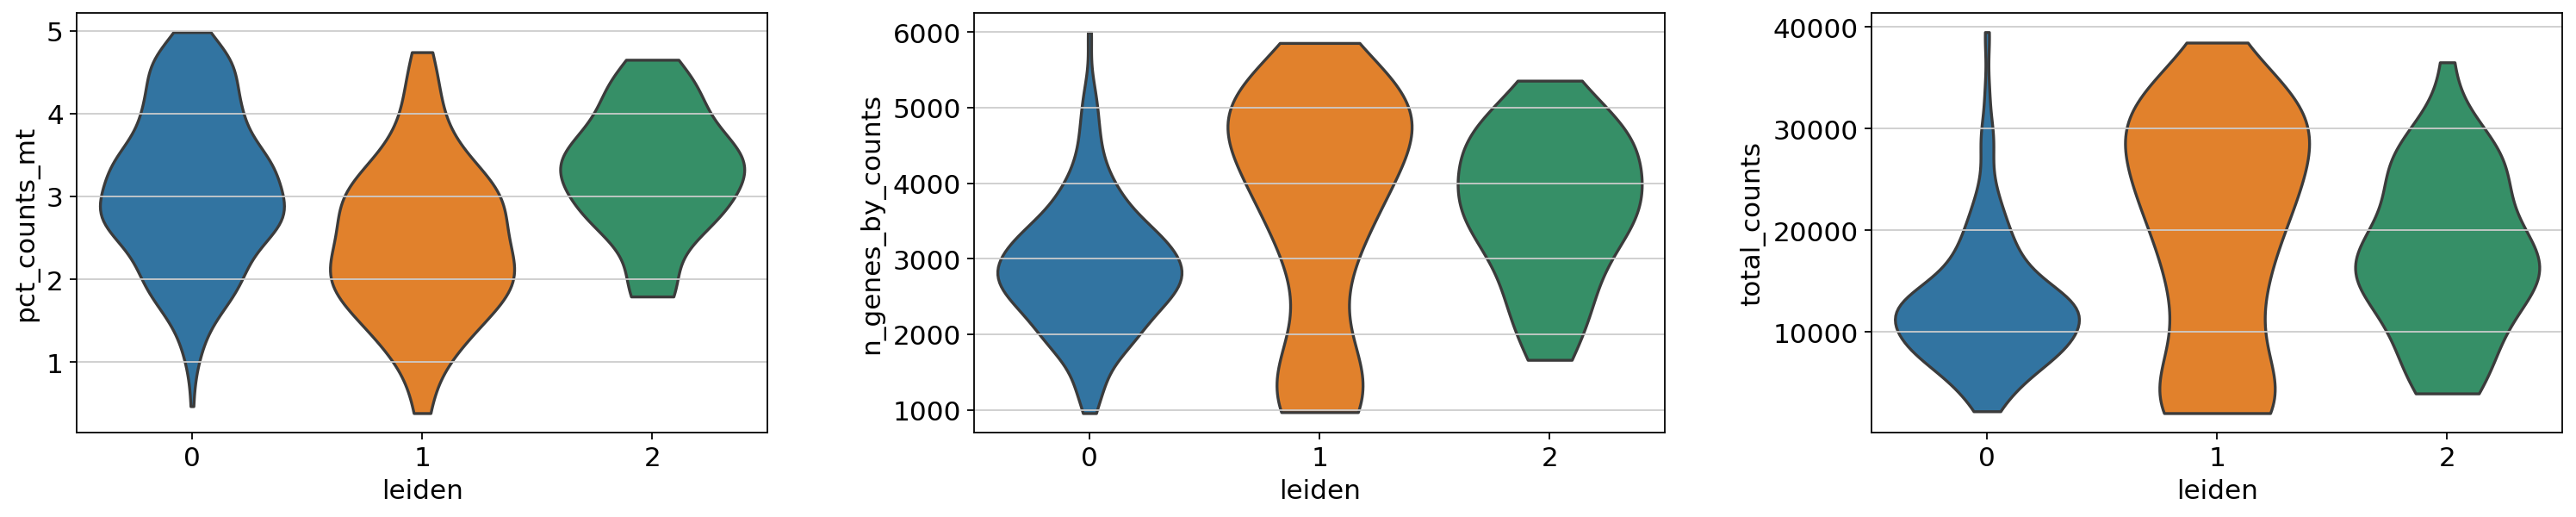

In [12]:
sc.set_figure_params(figsize=(6, 4))

sc.pl.violin(adata, ['pct_counts_mt', 'n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True, groupby='leiden', size=0)

In [13]:
# find marker genes
adata.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=False)
result = adata.uns['rank_genes_groups']

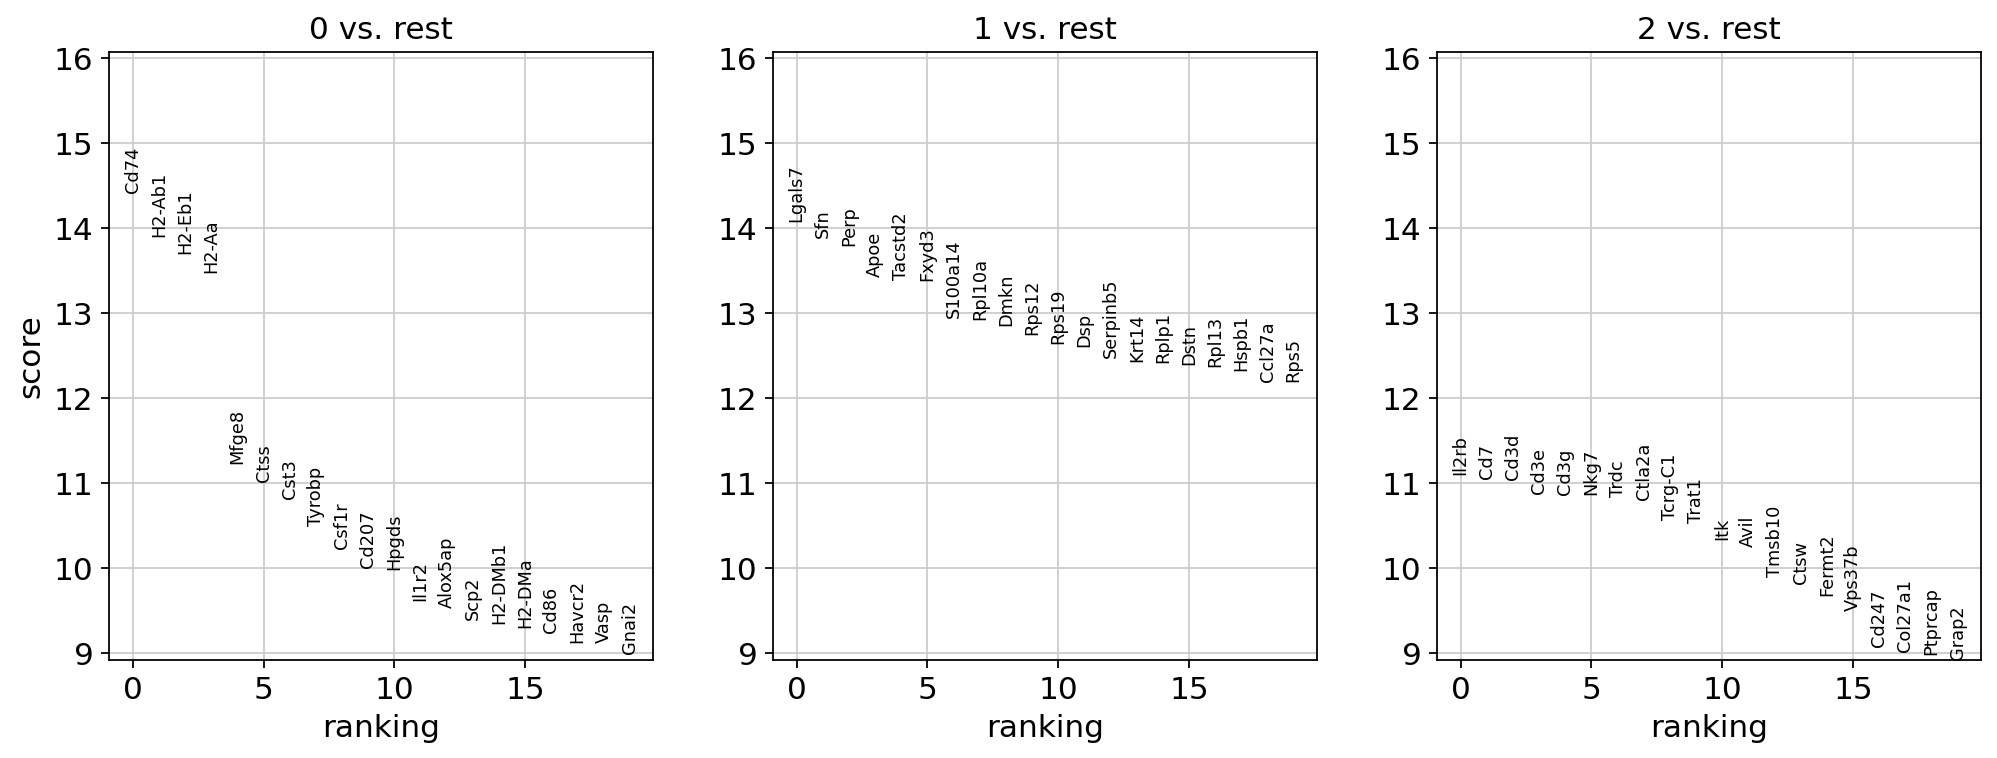

In [14]:
sc.set_figure_params(figsize=(5, 5))
sc.pl.rank_genes_groups(adata)

In [15]:
df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(200)

# Extract marker genes, log fold changes, and p-values
results = []
for cluster in adata.uns['rank_genes_groups']['names'].dtype.names:
    cluster_marker_genes = adata.uns['rank_genes_groups']['names'][cluster]
    logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges'][cluster]
    pvals = adata.uns['rank_genes_groups']['pvals'][cluster]
    pvals_adj = adata.uns['rank_genes_groups']['pvals_adj'][cluster]
    
    for gene, logfc, pval, pval_adj in zip(cluster_marker_genes, logfoldchanges, pvals, pvals_adj):
        results.append({
            'gene': gene,
            'log fold change': logfc,
            'p-value': pval,
            'adjusted p-value': pval_adj,
            'cluster': cluster
        })
        
# Convert to DataFrame
markers_df = pd.DataFrame(results)

In [16]:
markers_df.head()

,gene,log fold change,p-value,adjusted p-value,cluster
0,Cd74,1.671366,3.656035e-47,6.764762e-43,0
1,H2-Ab1,1.808972,6.492389e-44,6.006433e-40,0
2,H2-Eb1,1.688318,1.049104e-42,6.470524e-39,0
3,H2-Aa,1.564589,2.091658e-41,9.675486e-38,0
4,Mfge8,2.493625,2.821287e-29,8.700379e-26,0


In [17]:
markers_df.to_csv(f'{out_dir}/top_200_markers.csv', index=False)

In [18]:
# we can compute the cell-type composition between control and SSc
df_prop = pd.crosstab(adata.obs['sample'],adata.obs['leiden'], normalize='index').reset_index()
df_obs = adata.obs[['sample', 'time_point']].drop_duplicates()
df_prop = pd.melt(df_prop, id_vars=['sample'], value_name='proportion')
df = df_prop.merge(df_obs)

In [19]:
df

,sample,leiden,proportion,time_point
0,day0_sample1,0,0.714286,day0
1,day3_sample1,0,0.750000,day3
2,day3_sample2,0,0.866667,day3
3,day7_sample1,0,0.825397,day7
4,day7_sample2,0,0.823529,day7
5,day14_sample1,0,0.611111,day14
6,day14_sample2,0,0.444444,day14
7,day28_sample1,0,0.714286,day28
8,day28_sample2,0,0.714286,day28
9,day0_sample1,1,0.214286,day0


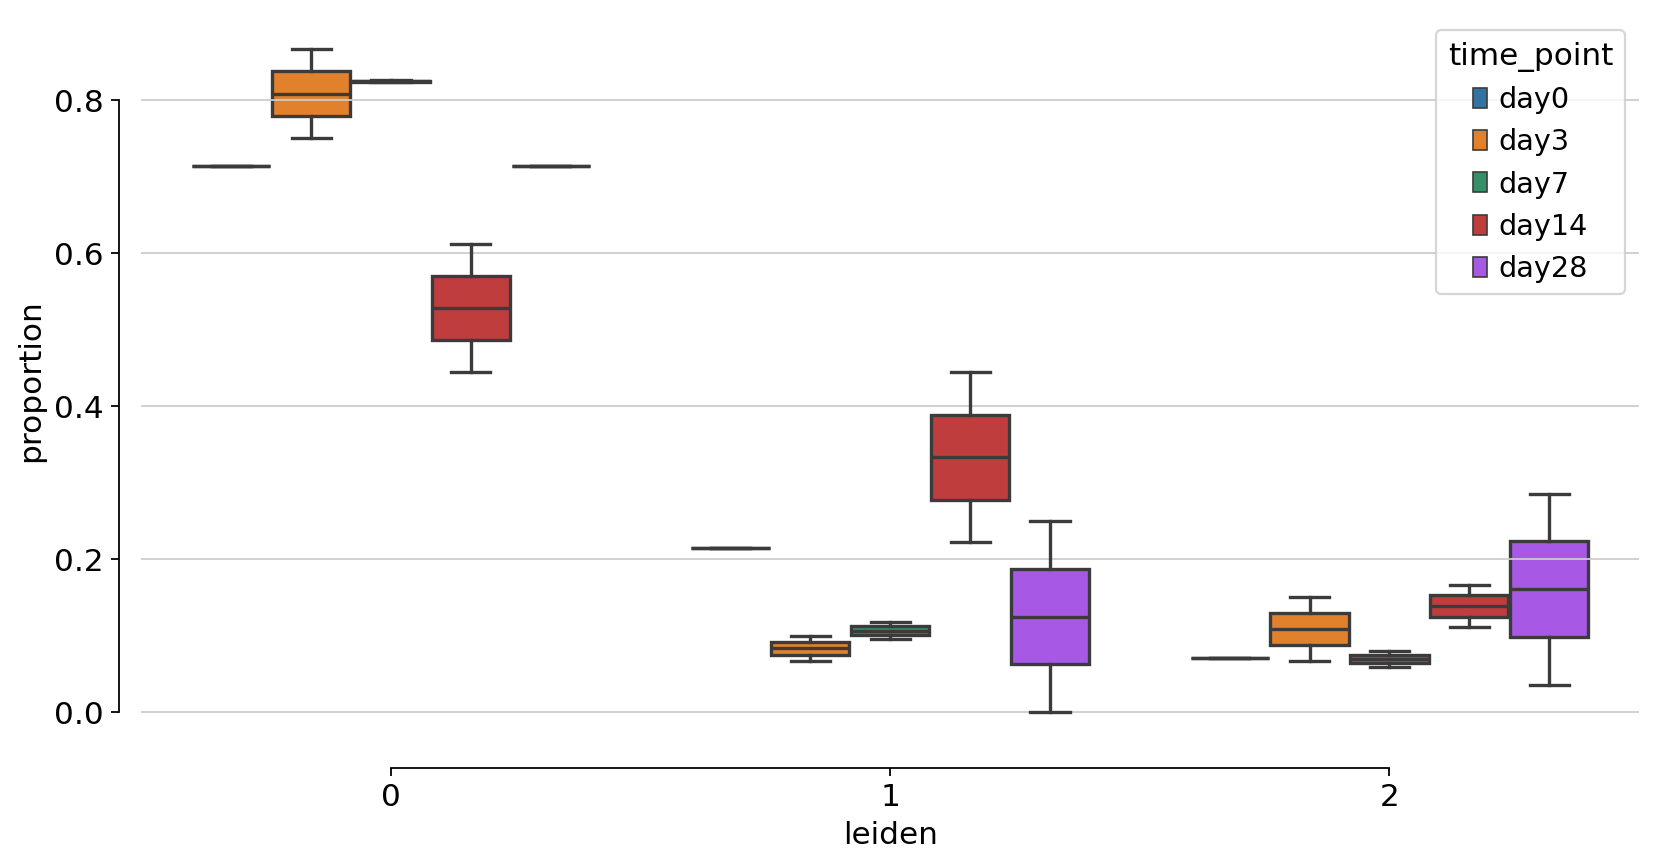

In [20]:
# visualize cell type proportion
sc.set_figure_params(figsize=(12, 6))
ax = sns.boxplot(data=df, 
                 x='leiden', y='proportion', 
                 hue="time_point", 
                 showfliers = False)
sns.despine(offset=10, trim=True, ax=ax)

In [21]:
df.to_csv(f'{out_dir}/cell_propotion.csv')

In [22]:
adata.write_h5ad(f'{out_dir}/adata.h5ad')